In [16]:
# make_csv.py
# Create csv file from the different json files

import json
import pandas as pd
import glob
from pathlib import Path

files = glob.glob("clinical_data/*.json")

rows = []

for f in files:
    with open(f, "r") as fp:
        data = json.load(fp)
        
        
       # Add filename without extension
        data["patient_id"] = Path(f).stem
        
        
        rows.append(data)

df = pd.DataFrame(rows)

df = pd.DataFrame(rows)
other_cols = [c for c in df.columns if c != "patient_id"]
df = df[["patient_id"] + other_cols]


df.to_csv("clinical_data.csv", index=False)

In [7]:
# preprocess_clinical_data.py
# Preprocesses clinical_data.csv to ensure proper training

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
import pandas as pd

df = pd.read_csv('clinical_data.csv')

# Handle missing values in binary columns, where missing value does not have meaning, by replacing missing value with 0
df["capsular_penetration"] = df["capsular_penetration"].replace("x", 0)

# Fill columns with NaNs as 0, BCR_PSA <0.1 means undectable, i.e. 0 and tertinary_gleason was not detected so 0 on the ordinal scale (1-5) 
df[["BCR_PSA", "tertiary_gleason"]] = df[["BCR_PSA", "tertiary_gleason"]].fillna(0)

df["BCR_PSA"] = df["BCR_PSA"].replace(" ", 0)

pT_mapping = {
    "1": 1,
    "1a": 2,
    "1b": 3,
    "1c": 4,
    "2": 5,
    "2a": 6,
    "2b": 7,
    "2c": 8,
    "3": 9,
    "3a": 10,
    "3b": 11,
    "4": 12,
    "4b":12
}

df["pT_stage"] = df["pT_stage"].map(pT_mapping)

# OneHotEncode categorical columns
categorical_cols = ["positive_lymph_nodes", "earlier_therapy"]

encoder = OneHotEncoder(
    sparse_output=False,
    handle_unknown="ignore"
)

encoded = encoder.fit_transform(df[categorical_cols])

encoded_df = pd.DataFrame(
    encoded,
    columns=encoder.get_feature_names_out(categorical_cols),
    index=df.index
)

df = df.drop(columns=categorical_cols) 
df = pd.concat([df, encoded_df], axis=1)
# scale numerical columns

scaler = StandardScaler()

numeric_cols = ["age_at_prostatectomy", "pre_operative_PSA", "BCR_PSA"]

df[numeric_cols] = scaler.fit_transform(df[numeric_cols])

df.to_csv("clinical_data_preprocessed.csv", index=False)

In [1]:
#cox_model.py
# Runs a cox proportional hazard model on the clinical data

import pandas as pd
from sksurv.util import Surv
from sksurv.linear_model import CoxPHSurvivalAnalysis
from sksurv.metrics import concordance_index_censored

df = pd.read_csv("clinical_data_preprocessed.csv")
splits = pd.read_csv("data_split_5fold.csv")

df = df.drop(columns=[c for c in df.columns if "earlier_therapy" in c.lower()])

df = df.merge(splits, on="patient_id")

c_indices = []

for fold in range(0, 5):

    # training set = all except current fold
    train_df = df[df["fold"] != fold]
    test_df   = df[df["fold"] == fold]

    # survival labels
    y_train = Surv.from_arrays(
        event=train_df["BCR"].astype(bool).values,
        time=train_df['time_to_follow-up/BCR'].values
    )
    y_test = Surv.from_arrays(
        event=test_df["BCR"].astype(bool).values,
        time=test_df["time_to_follow-up/BCR"].values
    )

    X_train = train_df.drop(columns=["BCR", "time_to_follow-up/BCR", "fold", "patient_id"])
    X_test = test_df.drop(columns=["BCR", "time_to_follow-up/BCR", "fold", "patient_id"])
    
    # fit Cox model
    model = CoxPHSurvivalAnalysis()
    model.fit(X_train, y_train)

    # predict on validation
    risk_val = model.predict(X_test)

    # compute C-index
    c_index = concordance_index_censored(
        test_df["BCR"].astype(bool).values,
        test_df["time_to_follow-up/BCR"].values,
        risk_val
    )[0]

    c_indices.append(c_index)
    print(f"Fold {fold} C-index: {c_index:.4f}")

Fold 0 C-index: 0.9405
Fold 1 C-index: 0.8764
Fold 2 C-index: 0.9221
Fold 3 C-index: 0.7308
Fold 4 C-index: 0.7797


/Users/vasconcelos_lab/miniforge3/envs/m31/lib/python3.11/site-packages/scipy/_lib/_util.py:1226: LinAlgWarning: Ill-conditioned matrix (rcond=3.12047e-18): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)
/Users/vasconcelos_lab/miniforge3/envs/m31/lib/python3.11/site-packages/scipy/_lib/_util.py:1226: LinAlgWarning: Ill-conditioned matrix (rcond=3.20295e-18): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)
/Users/vasconcelos_lab/miniforge3/envs/m31/lib/python3.11/site-packages/scipy/_lib/_util.py:1226: LinAlgWarning: Ill-conditioned matrix (rcond=5.83693e-18): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)
/Users/vasconcelos_lab/miniforge3/envs/m31/lib/python3.11/site-packages/scipy/_lib/_util.py:1226: LinAlgWarning: Ill-conditioned matrix (rcond=4.17266e-18): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)
/Users/vasconcelos_lab/miniforge3/envs/m31/lib/python3.11/site-packages/scipy/_lib/_util

adc shape: torch.Size([1, 160, 160, 48]) spacing: [1. 1. 3.]
hbv shape: torch.Size([1, 160, 160, 48]) spacing: [1. 1. 3.]
t2w shape: torch.Size([1, 160, 160, 48]) spacing: [1. 1. 3.]
mask shape: torch.Size([1, 160, 160, 48]) spacing: [1. 1. 3.]


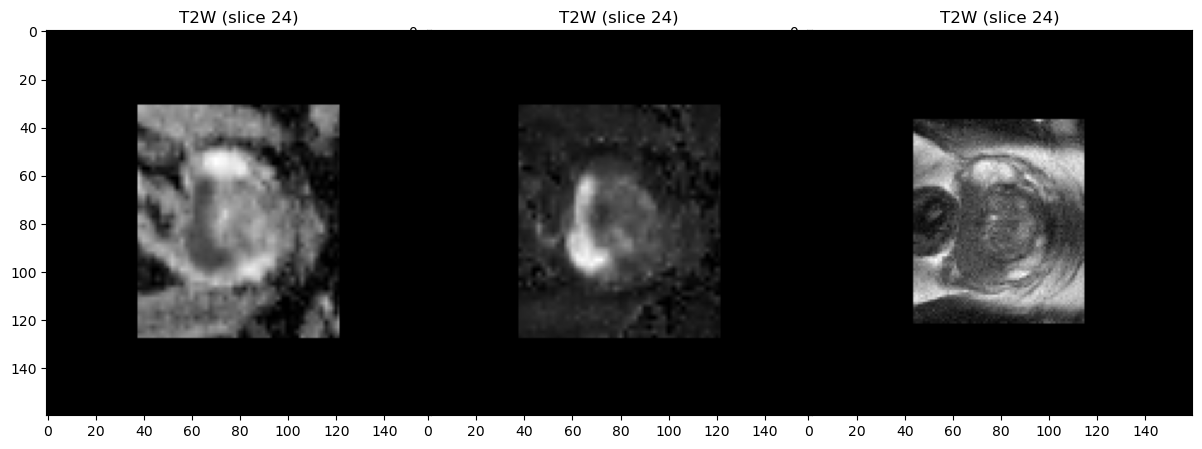

In [7]:
# preprocess_mri.py
# Preprocess 1 image of the mri

from monai.transforms import (
    LoadImaged,
    EnsureChannelFirstd,
    Orientationd,
    Spacingd,
    CropForegroundd,
    ResizeWithPadOrCropd,
    Compose,
    Resized,
    CopyItemsd,
    ConcatItemsd
)
from monai.data import ITKReader
import numpy as np
import matplotlib.pyplot as plt
import torch
from pathlib import Path
import os

# Get spacing
def get_spacing(img):
    A = img.meta["affine"].numpy()
    voxel_spacing = np.sqrt((A[:3, :3] ** 2).sum(axis=0))
    img.meta['affine_spacing'] = voxel_spacing
    return(img)



output_dir = "output"

if not os.path.exists(output_dir):
    os.makedirs(output_dir)
    print(f"Created folder: {output_dir}")
else:
    print(f"Folder already exists: {output_dir}")

root = Path("radiology/mpMRI")

# Get only patient folders, ignore hidden ones like .DS_Store
patient_dirs = [p for p in root.iterdir() if p.is_dir() and not p.name.startswith(".")]

for patient_dir in patient_dirs:
    patient_id = patient_dir.name

    adc_path  = f"radiology/mpMRI/{patient_id}/{patient_id}_0001_adc.mha"
    hbv_path  = f"radiology/mpMRI/{patient_id}/{patient_id}_0001_hbv.mha"
    t2w_path  = f"radiology/mpMRI/{patient_id}/{patient_id}_0001_t2w.mha"
    mask_path = f"radiology/prostate_mask_t2w/{patient_id}_0001_mask.mha"
    
    print(f"Working on patient: {patient_id}")
    print(f"adc_path: {adc_path}")
    print(f"hbv_path: {hbv_path}")
    print(f"t2w_path: {t2w_path}")
    print(f"mask_path: {mask_path}")

    data = {
        "adc": adc_path,
        "hbv": hbv_path,
        "t2w": t2w_path,
        "mask": mask_path,
    }

    target_spacing = (1.0, 1.0, 3.0)
    target_shape   = (160, 160, 48)   # pick something reasonable

    geom_transforms1 = Compose([
        # 1) LOAD FROM DISK
        LoadImaged(keys=["adc", "hbv", "t2w", "mask"],
                  reader=ITKReader(),
                  image_only = False),
        EnsureChannelFirstd(keys=["adc", "hbv", "t2w", "mask"]),

        # 2) ORIENT TO STANDARD AXES
        Orientationd(keys=["adc", "hbv", "t2w", "mask"], axcodes="RAS"),

        # 3) RESAMPLE TO TARGET SPACING
        Spacingd(
            keys=["adc", "hbv", "t2w"],
            pixdim=target_spacing,
            mode=("bilinear", "bilinear", "bilinear"),  # applies bilinear to each of adc, hbv, t2w
        ),
        Spacingd(
            keys=["mask"],
            pixdim=target_spacing,
            mode=("nearest",),
        ),
    ])

    out1 = geom_transforms1(data)

    mask_target_size = out1["adc"].shape[1:]

    geom_transforms2 = Compose([

        # create a copy called "mask_resampled"
        CopyItemsd(keys=["mask"], names=["mask_resampled"]),

         # now operate on that key
        Resized(
            keys=["mask_resampled"],
            spatial_size=mask_target_size,
            mode=("nearest"),
        ),

        CropForegroundd(
            keys=["t2w"],
            source_key="mask",         # use mask to define foreground
            margin=(16, 16, 2),        # extra voxels around bounding box (x,y,z)
        ),

        CropForegroundd(
            keys=["adc", "hbv"],
            source_key="mask_resampled",         # use mask to define foreground
            margin=(16, 16, 2),        # extra voxels around bounding box (x,y,z)
        ),

        # 5) FORCE FIXED SIZE (CENTERED PAD/CROP)
        ResizeWithPadOrCropd(
            keys=["adc", "hbv", "t2w", "mask", "mask_resampled"],
            spatial_size=target_shape,
        ),

        # 6) STACK MODALITIES INTO ONE TENSOR (C=3, X, Y, Z)
        ConcatItemsd(
            keys=["adc", "hbv", "t2w"],
            name="image",   # new key
            dim=0,          # channel dimension
        ),
    ])

    out2 = geom_transforms2(out1)

    adc = out2["adc"]
    hbv = out2["hbv"]
    t2w = out2["t2w"]
    mask = out2["mask"]
    image = out2["image"]


    adc = get_spacing(adc)
    hbv = get_spacing(hbv)
    t2w = get_spacing(t2w)
    mask = get_spacing(mask)

    print("adc shape:", adc.shape, "spacing:", adc.meta["affine_spacing"])
    print("hbv shape:", hbv.shape, "spacing:", hbv.meta["affine_spacing"])
    print("t2w shape:", t2w.shape, "spacing:", t2w.meta["affine_spacing"])
    print("mask shape:", mask.shape, "spacing:", mask.meta["affine_spacing"])

    output_patient_dir = output_dir + "/" + patient_id
    if not os.path.exists(output_patient_dir):
        os.makedirs(output_patient_dir)
    print(f"Created folder: {output_patient_dir}")

    # Path for this patient’s log file
    log_path = f"{output_patient_dir}/log.txt"

    # Write (overwrite) because this file is JUST for this patient
    with open(log_path, "w") as f:
        f.write(f"adc  shape: {adc.shape}, spacing: {adc.meta['affine_spacing']}\n")
        f.write(f"hbv  shape: {hbv.shape}, spacing: {hbv.meta['affine_spacing']}\n")
        f.write(f"t2w  shape: {t2w.shape}, spacing: {t2w.meta['affine_spacing']}\n")
        f.write(f"mask shape: {mask.shape}, spacing: {mask.meta['affine_spacing']}\n")

    img = out2["image"]  # shape (3, 160, 160, 48)

    # pick middle slice in Z
    z = img.shape[3] // 2

    fig, axs = plt.subplots(1, 3, figsize=(15,5))

    axs[0].imshow(img[0, :, :, z], cmap='gray')
    axs[0].set_title("ADC")

    axs[1].imshow(img[1, :, :, z], cmap='gray')
    axs[1].set_title("HBV")

    axs[2].imshow(img[2, :, :, z], cmap='gray')
    axs[2].set_title("T2W")

    plt.tight_layout()

    # ---- SAVE IMAGE PREVIEW ----
    img_path = f"{output_patient_dir}/images.png"
    plt.savefig(img_path, dpi=300, bbox_inches='tight')
    plt.close()   # <-- VERY important to avoid memory leaks in loops

    print(f"Saved preview image → {img_path}")

    # ---- SAVE FINAL TENSOR ----
    tensor_path = f"{output_patient_dir}/tensor.pt"
    torch.save(out2["image"], tensor_path)

    print(f"Saved tensor → {tensor_path}")

In [23]:
# preprocess_mri.py
# Preprocess 1 image of the mri

from monai.transforms import (
    LoadImaged,
    EnsureChannelFirstd,
    Orientationd,
    Spacingd,
    CropForegroundd,
    ResizeWithPadOrCropd,
    Compose,
    ResampleToMatchd,
    CopyItemsd,
    ConcatItemsd,
    NormalizeIntensityd,
    MapTransform
    
)
from monai.data import ITKReader
import numpy as np
import matplotlib.pyplot as plt
import torch
from pathlib import Path
import os

# Get spacing
def get_spacing(img):
    A = img.meta["affine"].numpy()
    voxel_spacing = np.sqrt((A[:3, :3] ** 2).sum(axis=0))
    img.meta['affine_spacing'] = voxel_spacing
    return(img)


class PercentileClippingd(MapTransform):
    """
    Clip intensity values for each key to given percentiles.
    Works with NumPy arrays or torch.Tensors, single- or multi-channel.
    """
    def __init__(self, keys, lower=0.5, upper=99.5):
        super().__init__(keys)
        self.lower = lower
        self.upper = upper

    def __call__(self, data):
        d = dict(data)
        for key in self.keys:
            img = d[key]

            # track whether this was a tensor so we can convert back
            is_tensor = isinstance(img, torch.Tensor)
            if is_tensor:
                img_np = img.detach().cpu().numpy()
            else:
                img_np = np.asarray(img)

            # compute percentiles ONLY on non-zero voxels
            nz = img_np[img_np != 0]

            if nz.size > 0:
                lo = np.percentile(nz, self.lower)
                hi = np.percentile(nz, self.upper)
                img_np = np.clip(img_np, lo, hi)

            # convert back to original type
            if is_tensor:
                d[key] = torch.as_tensor(img_np, device=img.device, dtype=img.dtype)
            else:
                d[key] = img_np

        return d


output_dir = "output"

if not os.path.exists(output_dir):
    os.makedirs(output_dir)
    print(f"Created folder: {output_dir}")
else:
    print(f"Folder already exists: {output_dir}")

root = Path("radiology/mpMRI")

# Get only patient folders, ignore hidden ones like .DS_Store
patient_dirs = [p for p in root.iterdir() if p.is_dir() and not p.name.startswith(".")]

for patient_dir in patient_dirs:
    patient_id = patient_dir.name

    adc_path  = f"radiology/mpMRI/{patient_id}/{patient_id}_0001_adc.mha"
    hbv_path  = f"radiology/mpMRI/{patient_id}/{patient_id}_0001_hbv.mha"
    t2w_path  = f"radiology/mpMRI/{patient_id}/{patient_id}_0001_t2w.mha"
    mask_path = f"radiology/prostate_mask_t2w/{patient_id}_0001_mask.mha"
    
    print(f"Working on patient: {patient_id}")
    print(f"adc_path: {adc_path}")
    print(f"hbv_path: {hbv_path}")
    print(f"t2w_path: {t2w_path}")
    print(f"mask_path: {mask_path}")

    data = {
        "adc": adc_path,
        "hbv": hbv_path,
        "t2w": t2w_path,
        "mask": mask_path,
    }

    target_spacing = (1.0, 1.0, 3.0)
    target_shape   = (160, 160, 48)   # pick something reasonable

    keys_img = ["adc", "hbv", "t2w"]
    keys_all = ["adc", "hbv", "t2w", "mask"]

    geom_transforms = Compose([
        # 1) LOAD
        LoadImaged(keys=keys_all, reader=ITKReader(), image_only=False),
        EnsureChannelFirstd(keys=keys_all),

        # 2) ORIENT ALL TO SAME AXES
        Orientationd(keys=keys_all, axcodes="RAS"),

        # 3) FIRST, SET T2W + MASK TO TARGET SPACING
        Spacingd(
            keys=["t2w"],
            pixdim=target_spacing,
            mode=("bilinear",),
        ),
        Spacingd(
            keys=["mask"],
            pixdim=target_spacing,
            mode=("nearest",),
        ),

        # 4) NOW RESAMPLE ADC + HBV TO EXACTLY MATCH T2W GRID
        ResampleToMatchd(
            keys=["adc", "hbv"],
            key_dst="t2w",                 # match t2w's shape + affine
            mode=("bilinear", "bilinear"),
        ),

        # at this point: adc, hbv, t2w, mask all same shape

        # 5) SINGLE CROP USING MASK AS SOURCE, APPLIED TO ALL
        CropForegroundd(
            keys=keys_all,
            source_key="mask",
            margin=(16, 16, 2),
        ),

        # 6) FIXED SIZE FOR THE NETWORK
        ResizeWithPadOrCropd(
            keys=keys_all,
            spatial_size=target_shape,
        ),
        
        PercentileClippingd(keys=keys_img, lower=0.5, upper=99.5),
        
        # 7) INTENSITY NORM ONLY ON IMAGE MODALITIES
        NormalizeIntensityd(
            keys=keys_img,
            nonzero=True,
            channel_wise=True,
        ),

        # 8) STACK IMAGE MODALITIES INTO (C=3, X, Y, Z)
        ConcatItemsd(
            keys=["adc", "hbv", "t2w"],
            name="image",
            dim=0,
        ),
    ])
    
    out = geom_transforms(data)

    adc = out["adc"]
    hbv = out["hbv"]
    t2w = out["t2w"]
    mask = out["mask"]
    image = out["image"]


    adc = get_spacing(adc)
    hbv = get_spacing(hbv)
    t2w = get_spacing(t2w)
    mask = get_spacing(mask)

    print("adc shape:", adc.shape, "spacing:", adc.meta["affine_spacing"])
    print("hbv shape:", hbv.shape, "spacing:", hbv.meta["affine_spacing"])
    print("t2w shape:", t2w.shape, "spacing:", t2w.meta["affine_spacing"])
    print("mask shape:", mask.shape, "spacing:", mask.meta["affine_spacing"])

    output_patient_dir = output_dir + "/" + patient_id
    if not os.path.exists(output_patient_dir):
        os.makedirs(output_patient_dir)
    print(f"Created folder: {output_patient_dir}")

    # Path for this patient’s log file
    log_path = f"{output_patient_dir}/log.txt"

    # Write (overwrite) because this file is JUST for this patient
    with open(log_path, "w") as f:
        f.write(f"adc  shape: {adc.shape}, spacing: {adc.meta['affine_spacing']}\n")
        f.write(f"hbv  shape: {hbv.shape}, spacing: {hbv.meta['affine_spacing']}\n")
        f.write(f"t2w  shape: {t2w.shape}, spacing: {t2w.meta['affine_spacing']}\n")
        f.write(f"mask shape: {mask.shape}, spacing: {mask.meta['affine_spacing']}\n")

    img = out["image"]  # shape (3, 160, 160, 48)

    # pick middle slice in Z
    z = img.shape[3] // 2

    fig, axs = plt.subplots(1, 3, figsize=(15,5))

    axs[0].imshow(img[0, :, :, z], cmap='gray')
    axs[0].set_title("ADC")

    axs[1].imshow(img[1, :, :, z], cmap='gray')
    axs[1].set_title("HBV")

    axs[2].imshow(img[2, :, :, z], cmap='gray')
    axs[2].set_title("T2W")

    plt.tight_layout()

    # ---- SAVE IMAGE PREVIEW ----
    img_path = f"{output_patient_dir}/images.png"
    plt.savefig(img_path, dpi=300, bbox_inches='tight')
    plt.close()   # <-- VERY important to avoid memory leaks in loops

    print(f"Saved preview image → {img_path}")

    # ---- SAVE FINAL TENSOR ----
    tensor_path = f"{output_patient_dir}/tensor.pt"
    torch.save(out["image"], tensor_path)

    print(f"Saved tensor → {tensor_path}")

Folder already exists: output
Working on patient: 1264
adc_path: radiology/mpMRI/1264/1264_0001_adc.mha
hbv_path: radiology/mpMRI/1264/1264_0001_hbv.mha
t2w_path: radiology/mpMRI/1264/1264_0001_t2w.mha
mask_path: radiology/prostate_mask_t2w/1264_0001_mask.mha
adc shape: torch.Size([1, 160, 160, 48]) spacing: [1. 1. 1.]
hbv shape: torch.Size([1, 160, 160, 48]) spacing: [1. 1. 1.]
t2w shape: torch.Size([1, 160, 160, 48]) spacing: [1. 1. 1.]
mask shape: torch.Size([1, 160, 160, 48]) spacing: [1. 1. 3.]
Created folder: output/1264
Saved preview image → output/1264/images.png
Saved tensor → output/1264/tensor.pt
Working on patient: 1056
adc_path: radiology/mpMRI/1056/1056_0001_adc.mha
hbv_path: radiology/mpMRI/1056/1056_0001_hbv.mha
t2w_path: radiology/mpMRI/1056/1056_0001_t2w.mha
mask_path: radiology/prostate_mask_t2w/1056_0001_mask.mha
adc shape: torch.Size([1, 160, 160, 48]) spacing: [1. 1. 1.]
hbv shape: torch.Size([1, 160, 160, 48]) spacing: [1. 1. 1.]
t2w shape: torch.Size([1, 160, 16

Folder already exists: output
Working on patient: 1264
adc_path: radiology/mpMRI/1264/1264_0001_adc.mha
hbv_path: radiology/mpMRI/1264/1264_0001_hbv.mha
t2w_path: radiology/mpMRI/1264/1264_0001_t2w.mha
mask_path: radiology/prostate_mask_t2w/1264_0001_mask.mha
adc shape: torch.Size([1, 160, 160, 48]) spacing: [1. 1. 3.]
hbv shape: torch.Size([1, 160, 160, 48]) spacing: [1. 1. 3.]
t2w shape: torch.Size([1, 160, 160, 48]) spacing: [1. 1. 3.]
mask shape: torch.Size([1, 160, 160, 48]) spacing: [1. 1. 3.]
Created folder: output/1264


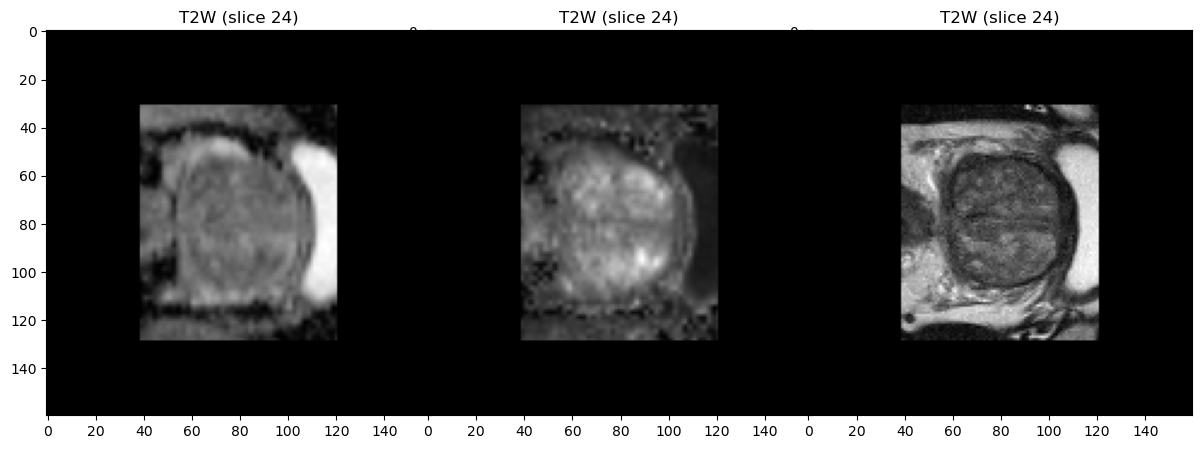

In [17]:
# preprocess_mri.py
# Preprocess 1 image of the mri

from monai.transforms import (
    LoadImaged,
    EnsureChannelFirstd,
    Orientationd,
    Spacingd,
    CropForegroundd,
    ResizeWithPadOrCropd,
    ResampleToMatchd,
    Compose,
    Resized,
    CopyItemsd,
    ConcatItemsd
)
from monai.data import ITKReader
import numpy as np
import matplotlib.pyplot as plt
import torch
from pathlib import Path
import os

# Get spacing
def get_spacing(img):
    A = img.meta["affine"].numpy()
    voxel_spacing = np.sqrt((A[:3, :3] ** 2).sum(axis=0))
    img.meta['affine_spacing'] = voxel_spacing
    return(img)

output_dir = "output"

if not os.path.exists(output_dir):
    os.makedirs(output_dir)
    print(f"Created folder: {output_dir}")
else:
    print(f"Folder already exists: {output_dir}")

root = Path("radiology/mpMRI")

# Get only patient folders, ignore hidden ones like .DS_Store
patient_dirs = [p for p in root.iterdir() if p.is_dir() and not p.name.startswith(".")]

patient_dirs = patient_dirs[0:1]

for patient_dir in patient_dirs:
    patient_id = patient_dir.name

    adc_path  = f"radiology/mpMRI/{patient_id}/{patient_id}_0001_adc.mha"
    hbv_path  = f"radiology/mpMRI/{patient_id}/{patient_id}_0001_hbv.mha"
    t2w_path  = f"radiology/mpMRI/{patient_id}/{patient_id}_0001_t2w.mha"
    mask_path = f"radiology/prostate_mask_t2w/{patient_id}_0001_mask.mha"
    
    print(f"Working on patient: {patient_id}")
    print(f"adc_path: {adc_path}")
    print(f"hbv_path: {hbv_path}")
    print(f"t2w_path: {t2w_path}")
    print(f"mask_path: {mask_path}")

    data = {
        "adc": adc_path,
        "hbv": hbv_path,
        "t2w": t2w_path,
        "mask": mask_path,
    }

    target_spacing = (1.0, 1.0, 3.0)
    target_shape   = (160, 160, 48)   # pick something reasonable
    
    keys_img = ["adc", "hbv", "t2w"]
    keys_all = ["adc", "hbv", "t2w", "mask"]

    geom_transforms = Compose([
        # 1) LOAD
        LoadImaged(keys=keys_all, reader=ITKReader(), image_only=False),
        EnsureChannelFirstd(keys=keys_all),

        # 2) ORIENT ALL TO SAME AXES
        Orientationd(keys=keys_all, axcodes="RAS"),

        # 3) FIRST, SET T2W + MASK TO TARGET SPACING
        Spacingd(
            keys=["t2w"],
            pixdim=target_spacing,
            mode=("bilinear",),
        ),
        Spacingd(
            keys=["mask"],
            pixdim=target_spacing,
            mode=("nearest",),
        ),

        # 4) NOW RESAMPLE ADC + HBV TO EXACTLY MATCH T2W GRID
        ResampleToMatchd(
            keys=["adc", "hbv"],
            key_dst="t2w",                 # match t2w's shape + affine
            mode=("bilinear", "bilinear"),
        ),

        # at this point: adc, hbv, t2w, mask all same shape

        # 5) SINGLE CROP USING MASK AS SOURCE, APPLIED TO ALL
        CropForegroundd(
            keys=keys_all,
            source_key="mask",
            margin=(16, 16, 2),
        ),

        # 6) FIXED SIZE FOR THE NETWORK
        ResizeWithPadOrCropd(
            keys=keys_all,
            spatial_size=target_shape,
        ),
        
        # 7) INTENSITY NORM ONLY ON IMAGE MODALITIES
        NormalizeIntensityd(
            keys=keys_img,
            nonzero=True,
            channel_wise=True,
        ),

        # 8) STACK IMAGE MODALITIES INTO (C=3, X, Y, Z)
        ConcatItemsd(
            keys=["adc", "hbv", "t2w"],
            name="image",
            dim=0,
        ),
])
    
    out1 = geom_transforms(data)

    adc = out1["adc"]
    hbv = out1["hbv"]
    t2w = out1["t2w"]
    mask = out1["mask"]

    adc = get_spacing(adc)
    hbv = get_spacing(hbv)
    t2w = get_spacing(t2w)
    mask = get_spacing(mask)

    print("adc shape:", adc.shape, "spacing:", adc.meta["affine_spacing"])
    print("hbv shape:", hbv.shape, "spacing:", hbv.meta["affine_spacing"])
    print("t2w shape:", t2w.shape, "spacing:", t2w.meta["affine_spacing"])
    print("mask shape:", mask.shape, "spacing:", mask.meta["affine_spacing"])

    output_patient_dir = output_dir + "/" + patient_id
    if not os.path.exists(output_patient_dir):
        os.makedirs(output_patient_dir)
    print(f"Created folder: {output_patient_dir}")

    # Path for this patient’s log file
    log_path = f"{output_patient_dir}/log.txt"

    # Write (overwrite) because this file is JUST for this patient
    with open(log_path, "w") as f:
        f.write(f"adc  shape: {adc.shape}, spacing: {adc.meta['affine_spacing']}\n")
        f.write(f"hbv  shape: {hbv.shape}, spacing: {hbv.meta['affine_spacing']}\n")
        f.write(f"t2w  shape: {t2w.shape}, spacing: {t2w.meta['affine_spacing']}\n")
        f.write(f"mask shape: {mask.shape}, spacing: {mask.meta['affine_spacing']}\n")

    img1 = out1["adc"][0]      # shape (1, X, Y, Z) → take channel 0
    img2 = out1["t2w"][0]    # shape (1, X, Y, Z)
    img3 = out1["hbv"][0]

    # pick middle slice in Z
    z1 = img1.shape[2] // 2
    z2 = img2.shape[2] // 2
    z3 = img3.shape[2] // 2

    plt.figure(figsize=(18,5))
    plt.subplot(1,2,1)
    plt.imshow(img1[:,:,z1], cmap='gray')
    plt.title("T2W (slice {})".format(z1))

    plt.subplot(1,2,2)
    plt.imshow(img2[:,:,z2], cmap='gray')
    plt.title("T2W (slice {})".format(z2))

    plt.subplot(1,3,2)
    plt.imshow(img3[:,:,z3], cmap='gray')
    plt.title("T2W (slice {})".format(z3))

    plt.show()

In [6]:
root = Path("radiology/mpMRI")

# Get only patient folders, ignore hidden ones like .DS_Store
patient_dirs = [p for p in root.iterdir() if p.is_dir() and not p.name.startswith(".")]

patient_dirs = patient_dirs[0:2]

patient_dirs

[PosixPath('radiology/mpMRI/1264'), PosixPath('radiology/mpMRI/1056')]

In [ ]:
# pick one example
adc_path  = "radiology/mpMRI/1003/1003_0001_adc.mha"
hbv_path  = "radiology/mpMRI/1003/1003_0001_hbv.mha"
t2w_path  = "radiology/mpMRI/1003/1003_0001_t2w.mha"
mask_path = "radiology/prostate_mask_t2w/1003_0001_mask.mha"

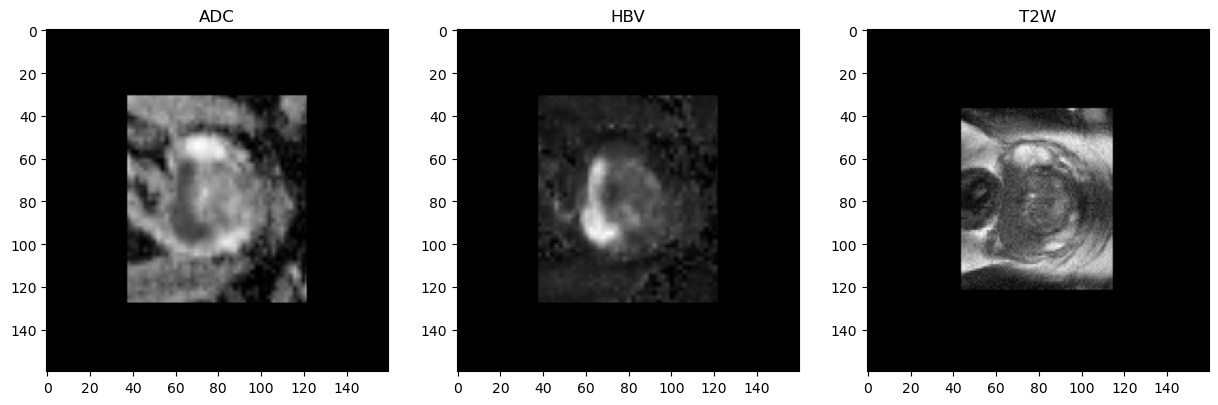

In [8]:
import matplotlib.pyplot as plt

img = out["image"]  # shape (3, 160, 160, 48)

# pick middle slice in Z
z = img.shape[3] // 2

fig, axs = plt.subplots(1, 3, figsize=(15,5))

axs[0].imshow(img[0, :, :, z], cmap='gray')
axs[0].set_title("ADC")

axs[1].imshow(img[1, :, :, z], cmap='gray')
axs[1].set_title("HBV")

axs[2].imshow(img[2, :, :, z], cmap='gray')
axs[2].set_title("T2W")

plt.show()

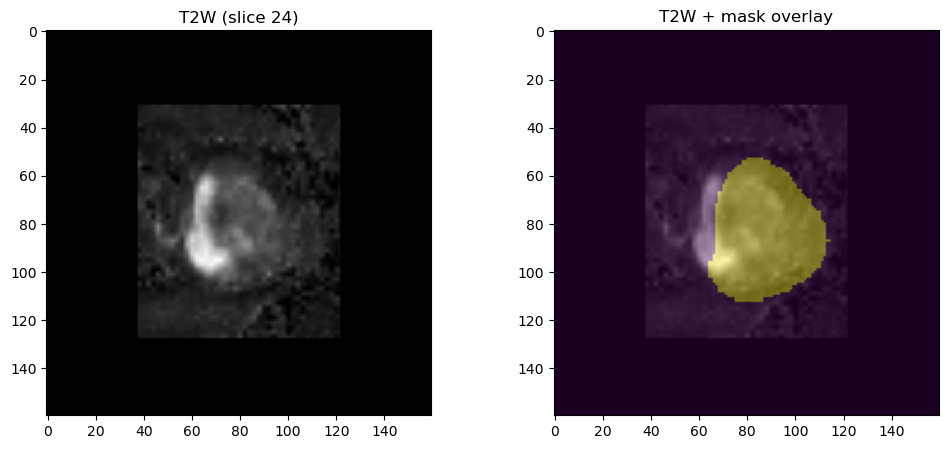

In [5]:
import matplotlib.pyplot as plt

img = out["hbv"][0]      # shape (1, X, Y, Z) → take channel 0
img_mask = out["mask_resampled"][0]    # shape (1, X, Y, Z)

# pick middle slice in Z
z = img.shape[2] // 2

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.imshow(img[:,:,z], cmap='gray')
plt.title("T2W (slice {})".format(z))

plt.subplot(1,2,2)
plt.imshow(img[:,:,z], cmap='gray')
plt.imshow(img_mask[:,:,z], alpha=0.4)   # overlay mask
plt.title("T2W + mask overlay")
plt.show()

In [51]:
#inspect_meta.py
# File to inspect metadata

import pandas as pd
from pathlib import Path
import SimpleITK as sitk

root = Path("radiology/mpMRI")

# Get only patient folders, ignore hidden ones like .DS_Store
patient_dirs = [p for p in root.iterdir() if p.is_dir() and not p.name.startswith(".")]

# Initiate empty list
rows = []

for patient_dir in patient_dirs:
    patient_id = patient_dir.name

    # all .mha files in this patient's folder
    mha_files = sorted(patient_dir.glob("*.mha"))

    for fpath in mha_files:
        # read image
        img = sitk.ReadImage(str(fpath))
        
        # get type
        img_type = fpath.stem.split("_")[-1]

        # geometry
        size = img.GetSize()        # (x, y, z)
        spacing = img.GetSpacing()  # (sx, sy, sz)
        direction = img.GetDirection()  # 3x3 matrix flattened to length-9 tuple

        # one row per file
        rows.append({
            "patient_id": patient_id,
            "file_path": str(fpath),
            "img_type": img_type,
            "size_x": size[0],
            "size_y": size[1],
            "size_z": size[2],
            "spacing_x": spacing[0],
            "spacing_y": spacing[1],
            "spacing_z": spacing[2],
            "direction": direction,  # keep as tuple; you can unpack later if needed
        })

# convert to DataFrame
df = pd.DataFrame(rows)

df["spacing_x_round"] = df["spacing_x"].round(2)
df["spacing_y_round"] = df["spacing_y"].round(2)
df["spacing_z_round"] = df["spacing_z"].round(2)


df.to_csv("metadata.csv")

In [2]:
from monai.transforms import (
    LoadImaged,
    EnsureChannelFirstd,
    Orientationd,
    Spacingd,
    CropForegroundd,
    ResizeWithPadOrCropd,
    Compose,
)
from monai.data import ITKReader
import numpy as np

# pick one example
adc_path  = "radiology/mpMRI/1003/1003_0001_adc.mha"
hbv_path  = "radiology/mpMRI/1003/1003_0001_hbv.mha"
t2w_path  = "radiology/mpMRI/1003/1003_0001_t2w.mha"
mask_path = "radiology/prostate_mask_t2w/1003_0001_mask.mha"

data = {
    "adc": adc_path,
    "hbv": hbv_path,
    "t2w": t2w_path,
    "mask": mask_path,
}

target_spacing = (1.0, 1.0, 3.0)
target_shape   = (160, 160, 48)   # pick something reasonable

geom_transforms = Compose([
    # 1) LOAD FROM DISK
    LoadImaged(keys=["adc", "hbv", "t2w", "mask"],
              reader=ITKReader(),
              image_only = False),
    EnsureChannelFirstd(keys=["adc", "hbv", "t2w", "mask"]),

    # 2) ORIENT TO STANDARD AXES
    Orientationd(keys=["adc", "hbv", "t2w", "mask"], axcodes="RAS"),

    # 3) RESAMPLE TO TARGET SPACING
    Spacingd(
        keys=["adc", "hbv", "t2w"],
        pixdim=target_spacing,
        mode=("bilinear", "bilinear", "bilinear"),  # applies bilinear to each of adc, hbv, t2w
    ),
    Spacingd(
        keys=["mask"],
        pixdim=target_spacing,
        mode=("nearest",),
    ),
        CropForegroundd(
        keys=["adc", "hbv", "t2w", "mask"],
        source_key="mask",         # use mask to define foreground
        margin=(16, 16, 2),        # extra voxels around bounding box (x,y,z)
    ),
    
    # 5) FORCE FIXED SIZE (CENTERED PAD/CROP)
    ResizeWithPadOrCropd(
        keys=["adc", "hbv", "t2w", "mask"],
        spatial_size=target_shape,
    ),


])

out = geom_transforms(data)

adc = out["adc"]
hbv = out["hbv"]
t2w = out["t2w"]
mask = out["mask"]

# Get spacing

def get_spacing(img):
    A = img.meta["affine"].numpy()
    voxel_spacing = np.sqrt((A[:3, :3] ** 2).sum(axis=0))
    img.meta['affine_spacing'] = voxel_spacing
    return(img)

adc = get_spacing(adc)
hbv = get_spacing(hbv)
t2w = get_spacing(t2w)
mask = get_spacing(mask)

print("adc shape:", adc.shape, "spacing:", adc.meta["affine_spacing"])
print("hbv shape:", hbv.shape, "spacing:", hbv.meta["affine_spacing"])
print("t2w shape:", t2w.shape, "spacing:", t2w.meta["affine_spacing"])
print("mask shape:", mask.shape, "spacing:", mask.meta["affine_spacing"])

adc shape: torch.Size([1, 160, 160, 48]) spacing: [1. 1. 3.]
hbv shape: torch.Size([1, 160, 160, 48]) spacing: [1. 1. 3.]
t2w shape: torch.Size([1, 160, 160, 48]) spacing: [1. 1. 3.]
mask shape: torch.Size([1, 160, 160, 48]) spacing: [1. 1. 3.]


In [51]:
from monai.transforms import Resize

# Define the target spatial size
target_size = (239, 255, 23) 

# Create the Resize transform
# mode='trilinear' is suitable for 3D medical images; other options like 'bilinear', 'nearest' are available
resize_transform = Resize(spatial_size=target_size, mode='nearest')

# Apply the transform
mask_resampled = resize_transform(mask)

print(f"Original shape: {mask.shape}")
print(f"Resized shape: {output_tensor.shape}")

Original shape: torch.Size([1, 193, 193, 23])
Resized shape: torch.Size([1, 239, 255, 23])


In [50]:
mask.shape

torch.Size([1, 193, 193, 23])

adc shape: torch.Size([1, 160, 160, 48]) spacing: [1. 1. 3.]
hbv shape: torch.Size([1, 160, 160, 48]) spacing: [1. 1. 3.]
t2w shape: torch.Size([1, 160, 160, 48]) spacing: [1. 1. 3.]
mask shape: torch.Size([1, 160, 160, 48]) spacing: [1. 1. 3.]


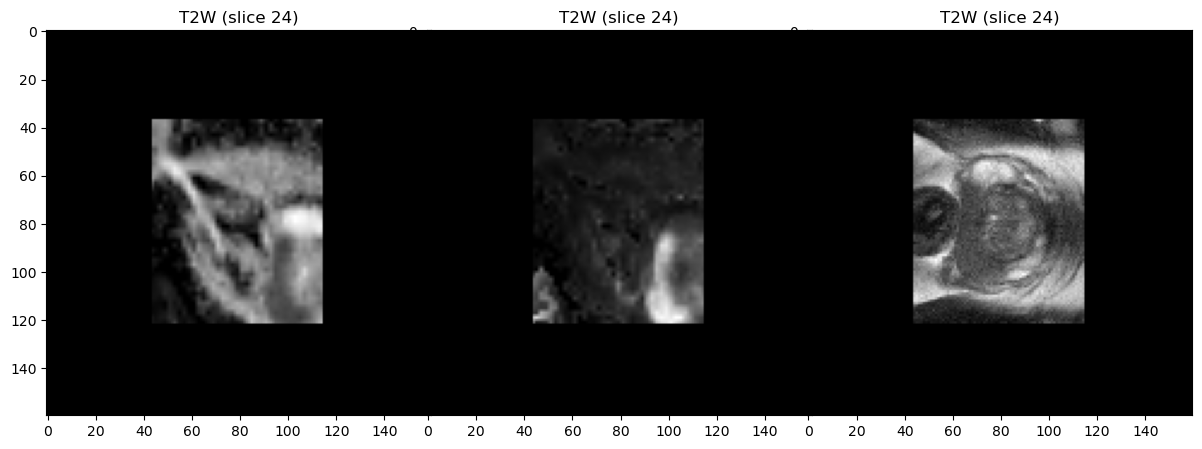

In [3]:
import matplotlib.pyplot as plt

img1 = out["adc"][0]      # shape (1, X, Y, Z) → take channel 0
img2 = out["t2w"][0]    # shape (1, X, Y, Z)
img3 = out["hbv"][0]

# pick middle slice in Z
z1 = img1.shape[2] // 2
z2 = img2.shape[2] // 2
z3 = img3.shape[2] // 2

plt.figure(figsize=(18,5))
plt.subplot(1,2,1)
plt.imshow(img1[:,:,z1], cmap='gray')
plt.title("T2W (slice {})".format(z1))

plt.subplot(1,2,2)
plt.imshow(img2[:,:,z2], cmap='gray')
plt.title("T2W (slice {})".format(z2))

plt.subplot(1,3,2)
plt.imshow(img3[:,:,z3], cmap='gray')
plt.title("T2W (slice {})".format(z3))

plt.show()

In [11]:
adc.meta["affine"]

tensor([[ 1.0000e+00, -4.8970e-12,  9.5965e-16, -1.1663e+02],
        [ 4.8675e-12,  9.9396e-01, -3.2920e-01, -1.3673e+02],
        [ 5.3705e-13,  1.0973e-01,  2.9819e+00, -6.6610e+01],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00]],
       dtype=torch.float64)

In [41]:
import SimpleITK as sitk
import glob
import os 

os.listdir("radiology/mpMRI/")


files = glob.glob("radiology/mpMRI/1003/1003_0001_adc.mha"

img = sitk.ReadImage("radiology/prostate_mask_t2w/1003_0001_mask.mha")

In [37]:
img

<SimpleITK.SimpleITK.Image; proxy of <Swig Object of type 'std::vector< itk::simple::Image >::value_type *' at 0x1095a0c60> >

In [42]:
print("Size:", img.GetSize()) 

Size: (640, 640, 19)


In [43]:
for k in img.GetMetaDataKeys():
    print(f"{k}:", img.GetMetaData(k))

ITK_InputFilterName: MetaImageIO
ITK_original_direction: [UNKNOWN_PRINT_CHARACTERISTICS]

ITK_original_spacing: [UNKNOWN_PRINT_CHARACTERISTICS]

ITK_sform_corrected: NO
bitpix: 8
cal_max: 0
cal_min: 0
datatype: 2
dim[0]: 3
dim[1]: 640
dim[2]: 640
dim[3]: 19
dim[4]: 1
dim[5]: 1
dim[6]: 1
dim[7]: 1
dim_info: 0
intent_code: 0
intent_p1: 0
intent_p2: 0
intent_p3: 0
nifti_type: 1
pixdim[0]: 0
pixdim[1]: 0.3
pixdim[2]: 0.3
pixdim[3]: 3.6
pixdim[4]: 0
pixdim[5]: 0
pixdim[6]: 0
pixdim[7]: 0
qfac: 1
qform_code: 1
qform_code_name: NIFTI_XFORM_SCANNER_ANAT
qoffset_x: 97.3668
qoffset_y: 83.9245
qoffset_z: -42.2491
quatern_b: 1.34386e-13
quatern_c: 0.0549502
quatern_d: -0.998489
scl_inter: 0
scl_slope: 1
sform_code: 1
sform_code_name: NIFTI_XFORM_SCANNER_ANAT
slice_code: 0
slice_duration: 0
slice_end: 0
slice_start: 0
srow_x: -0.3 1.4691e-12 1.15134e-15 97.3668
srow_y: -1.46024e-12 -0.298188 -0.395043 83.9245
srow_z: -1.61115e-13 -0.0329203 3.57826 -42.2491
toffset: 0
vox_offset: 352
xyzt_units: 2


In [44]:
print("Size:", img.GetSize())          # (x, y, z)
print("Spacing:", img.GetSpacing())    # voxel size in mm
print("Origin:", img.GetOrigin())
print("Direction:", img.GetDirection())

Size: (640, 640, 19)
Spacing: (0.30000001192092896, 0.30000001192092896, 3.5999999046325684)
Origin: (-97.36680603027344, -83.92451477050781, -42.249080657958984)
Direction: (1.0, -4.896999857548013e-12, -3.1981755137108703e-16, 4.867461853430663e-12, 0.993960957237057, 0.1097342944733968, -5.370509867080974e-13, -0.10973429495100198, 0.9939609572897851)
